In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import requests
sess = tf.Session()

D:\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
with open('lowbwt.txt', 'r') as file:
    birth_data = [[float(data) for data in line.strip('\n').split()] for line in file.readlines()]
birth_header = ["ID", "LBW", "AGE", "LWT", "RACE", "SMOKE", "PTL", "HYPER", "URIRR", "PVFT", "BWT"]
cols_of_interest = ['AGE', 'LWT', 'RACE', 'SMOKE', 'PTL', 'HYPER', 'URIRR', 'PVFT']
x_vals = np.array([[x[i] for i, val in enumerate(birth_header) if val in cols_of_interest] for x in birth_data])
y_vals = np.array([y[1] for y in birth_data])
train_indices = np.random.choice(len(x_vals), round(len(x_vals) * 0.8), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]
def normalize_cols(m):
    col_max = m.max(axis=0)
    col_min = m.min(axis=0)
    return (m - col_min) / (col_max - col_min)

x_vals_train = np.nan_to_num(normalize_cols(x_vals_train))
x_vals_test = np.nan_to_num(normalize_cols(x_vals_test))

In [3]:
batch_size = 64
x_data = tf.placeholder(shape=[None, 8], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

In [4]:
def init_variable(shape):
    return tf.Variable(tf.random_normal(shape=shape))

def logistic(input_layer, multiplication_weight, bias_weight, activation=True):
    linear_layer = tf.add(tf.matmul(input_layer, multiplication_weight), bias_weight)
    
    if activation:
        return tf.nn.sigmoid(linear_layer)
    else:
        return linear_layer

In [5]:
A1 = init_variable(shape=[8, 16])
b1 = init_variable(shape=[16])
logistic_layer1 = logistic(x_data, A1, b1)
A2 = init_variable(shape=[16, 5])
b2 = init_variable(shape=[5])
logistic_layer2 = logistic(logistic_layer1, A2, b2)
A3 = init_variable(shape=[5, 1])
b3 = init_variable(shape=[1])
final_output = logistic(logistic_layer2, A3, b3, activation=False)

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=final_output, labels=y_target))
my_opt = tf.train.AdamOptimizer(learning_rate=0.002)
train_step = my_opt.minimize(loss)
init = tf.global_variables_initializer()
sess.run(init)

In [7]:
prediction = tf.round(tf.nn.sigmoid(final_output))
predictions_correct = tf.cast(tf.equal(prediction, y_target), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

In [8]:
loss_vec = []
train_acc = []
test_acc = []

for i in range(1500):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = x_vals_train[rand_index]
    rand_y = np.transpose([y_vals_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target:rand_y})
    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)
    temp_acc_train = sess.run(accuracy, feed_dict={x_data: x_vals_train, y_target: np.transpose([y_vals_train])})
    train_acc.append(temp_acc_train)
    temp_acc_test = sess.run(accuracy, feed_dict={x_data: x_vals_test, y_target:np.transpose([y_vals_test])})
    test_acc.append(temp_acc_test)
    if (i + 1) % 150 == 0:
        print('Loss = ' + str(temp_loss))

Loss = 0.65449893
Loss = 0.61721903
Loss = 0.551445
Loss = 0.54549026
Loss = 0.59243995
Loss = 0.5596266
Loss = 0.5974259
Loss = 0.49814543
Loss = 0.48470688
Loss = 0.4929136


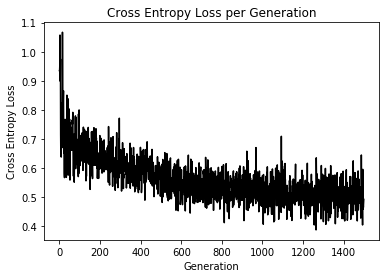

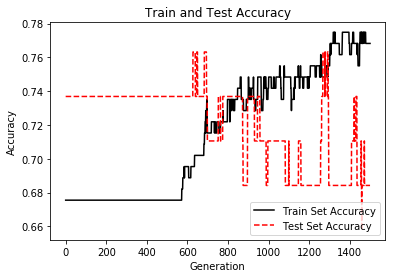

In [9]:
plt.plot(loss_vec, 'k-')
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.show()
plt.plot(train_acc, 'k-', label='Train Set Accuracy')
plt.plot(test_acc, 'r--', label='Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()